## Neural Network Approach For Functions Of Matrices

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import numpy as np
from scipy.linalg import expm
import math

import matplotlib.pyplot as plt

import csv
import os

import datetime

In [2]:
ID = datetime.datetime.strftime(datetime.datetime.now(),'%Y%M%d%s')

In [3]:
# Create a directory for saving results
save_dir = os.path.join(os.getcwd(), 'matrix_exp_results', ID)
os.makedirs(save_dir, exist_ok=True)

In [4]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Define the neural network
class MatrixExponentialNet(nn.Module):
    def __init__(self, input_size):
        super(MatrixExponentialNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, input_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [7]:
# Define input size (5x5 matrix flattened)
input_size = 5 * 5

In [8]:
# params
distribution = "gaussian" # or uniform
matrix_type = "wigner"
coeff_lower = 0 
coeff_upper = 2

lr = 1e-5 # learning rate

In [9]:
# Create the model and move it to GPU
model = MatrixExponentialNet(input_size).to(device)

In [10]:
test = torch.randn(5)*5000
print(f"{test=}")
torch.abs(torch.sin(torch.abs(test)))

test=tensor([-2226.3259, -3185.2048, -1501.0999,  -121.7280, -9121.1221])


tensor([0.8739, 0.3617, 0.5492, 0.7132, 0.8813])

In [11]:
class MatrixLoss(nn.Module):
    def __init__(self, dim=5):
        super(MatrixLoss, self).__init__()
        self.dim = dim

    def forward(self, pred, target):
        e = pred - target
        e_reshaped = e.view(-1, self.dim, self.dim)
        
        max_abs = torch.max(torch.abs(e_reshaped).view(e_reshaped.size(0), -1), dim=1)[0]
        sum_abs = torch.sum(torch.abs(e_reshaped), dim=(1,2)) / self.dim
        trace = torch.sum(e_reshaped ** 2, dim=(1,2)) / self.dim
        
        loss = max_abs + sum_abs + trace
        loss = loss.mean()
        return F.log_softmax(loss)

In [12]:
class FrobeniusNormLoss(nn.Module):
    def __init__(self):
        super(FrobeniusNormLoss, self).__init__()

    def forward(self, pred, target):
        return torch.norm(pred - target, p='fro')

In [13]:
class LogFrobeniusNormLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super(LogFrobeniusNormLoss, self).__init__()
        self.eps = eps

    def forward(self, pred, target):
        frob_norm = torch.norm(pred - target, p='fro')
        return torch.log(frob_norm + self.eps)

In [14]:
# Define loss function and optimizer
# criterion = nn.MSELoss()
# criterion = MatrixLoss(dim=5)
# criterion = nn.CrossEntropyLoss()
# criterion = log_cosh_loss
# criterion = nn.HuberLoss()
# criterion = FrobeniusNormLoss()
criterion = LogFrobeniusNormLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [15]:
# Function to compute matrix exponential
def matrix_exponential(batch_matrices):
    return np.array([expm(A) for A in batch_matrices])

In [16]:
# Training loop
num_epochs = 100000
batch_size = 64

In [17]:
# Lists to store loss values for plotting
train_losses = []
val_losses = []

In [18]:
for epoch in range(num_epochs):
    model.train()
    # Generate random 5x5 matrices
    if distribution == "gaussian":
        A = np.random.randn(batch_size, 5, 5)
        A = np.array(coeff_upper / math.sqrt(3.0) * A)
    elif distribution == "uniform":
        A = np.random.rand(batch_size, 5, 5)
        A = np.array(max_coeff * (2 * A - 1))
    else:
        raise TypeError("Unsupported distribution")

    if matrix_type == "wigner":
        A_triu = np.triu(A, 1)
        A = A_triu + A_triu.transpose(0, 2, 1)
        diagonal = np.diag(np.random.randn(5)* 2**0.5 + 1) # Normal with mean=1 and var = 2
        A = A + diagonal
        
    
    # Calculate exp(A)
    A_exp = matrix_exponential(A) # (batch_size, dim, dim)
    
    # Convert to PyTorch tensors and move to GPU
    A_tensor = torch.FloatTensor(A).view(batch_size, -1).to(device)
    A_exp_tensor = torch.FloatTensor(A_exp).view(batch_size, -1).to(device)
    
    # Forward pass
    output = model(A_tensor) # (batch_size, dim * dim)
    
    # Compute loss
    loss = criterion(output, A_exp_tensor)
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Validation step
    if (epoch + 1) % 1000 == 0:
        model.eval()
        with torch.no_grad():
            if distribution == "gaussian":
                A_val = np.random.randn(batch_size, 5, 5)
                A_val = np.array(coeff_upper / math.sqrt(3.0) * A_val)
            elif distribution == "uniform":
                A_val = np.random.rand(batch_size, 5, 5)
                A_val = np.array(max_coeff * (2 * A_val - 1))
            else:
                raise TypeError("Unsupported distribution")
            # A_val = np.random.randn(batch_size, 5, 5)
            A_exp_val = matrix_exponential(A_val)
            A_val_tensor = torch.FloatTensor(A_val).view(batch_size, -1).to(device)
            A_exp_val_tensor = torch.FloatTensor(A_exp_val).view(batch_size, -1).to(device)
            val_output = model(A_val_tensor)
            val_loss = criterion(val_output, A_exp_val_tensor)
            val_losses.append(val_loss.item())
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
        # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():,.0f}, Val Loss: {val_loss.item():,.0f}')

Epoch [1000/100000], Train Loss: 7.7080, Val Loss: 5.0685
Epoch [2000/100000], Train Loss: 7.1899, Val Loss: 5.4148
Epoch [3000/100000], Train Loss: 8.7711, Val Loss: 5.6123
Epoch [4000/100000], Train Loss: 6.9972, Val Loss: 5.6543
Epoch [5000/100000], Train Loss: 8.1469, Val Loss: 5.8414
Epoch [6000/100000], Train Loss: 7.5015, Val Loss: 5.8709
Epoch [7000/100000], Train Loss: 6.8674, Val Loss: 5.6896
Epoch [8000/100000], Train Loss: 7.0479, Val Loss: 5.6991
Epoch [9000/100000], Train Loss: 8.6625, Val Loss: 5.6326
Epoch [10000/100000], Train Loss: 6.2787, Val Loss: 5.7635
Epoch [11000/100000], Train Loss: 7.1605, Val Loss: 5.6525
Epoch [12000/100000], Train Loss: 6.4982, Val Loss: 5.6664
Epoch [13000/100000], Train Loss: 7.0931, Val Loss: 5.6606
Epoch [14000/100000], Train Loss: 6.5308, Val Loss: 5.6096
Epoch [15000/100000], Train Loss: 6.9670, Val Loss: 5.7206
Epoch [16000/100000], Train Loss: 6.8534, Val Loss: 5.7855
Epoch [17000/100000], Train Loss: 7.5292, Val Loss: 5.9282
Epoch 

In [19]:
# Save the model
torch.save(model.state_dict(), os.path.join(save_dir, 'matrix_exp_model.pth'))

# Save loss lists
with open(os.path.join(save_dir, 'losses.csv'), 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Epoch', 'Train Loss', 'Validation Loss'])
    for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
        writer.writerow([i*100, train_loss, val_loss])

In [20]:
# Evaluation
model.eval()
with torch.no_grad():
    # Generate test matrices
    num_test = 1000

    if distribution == "gaussian":
        A_test = np.random.randn(num_test, 5, 5)
        A_test = np.array(coeff_upper / math.sqrt(3.0) * A_test)
    elif distribution == "uniform":
        A_test = np.random.rand(num_test, 5, 5)
        A_test = np.array(max_coeff * (2 * A_test - 1))
    else:
        raise TypeError("Unsupported distributon.")
    
    A_exp_test = matrix_exponential(A_test)
    
    # Convert to PyTorch tensors and move to GPU
    A_test_tensor = torch.FloatTensor(A_test).view(num_test, -1).to(device)
    A_exp_test_tensor = torch.FloatTensor(A_exp_test).view(num_test, -1).to(device)
    
    # Get model predictions
    predictions = model(A_test_tensor)
    
    # Compute test loss
    test_loss = criterion(predictions, A_exp_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Compare a few results
    for i in range(3):
        print(f"\nExample {i+1}:")
        print("Input matrix A:")
        print(A_test[i])
        print("Actual exp(A):")
        print(A_exp_test[i])
        print("Predicted exp(A):")
        print(predictions[i].view(5, 5).cpu().numpy())

Test Loss: 7.0673

Example 1:
Input matrix A:
[[ 1.26420834 -1.13137578 -0.29372485  0.18360149 -1.49369498]
 [ 0.50421503 -1.11331967 -0.43866284  1.19570117 -0.79211211]
 [-1.76511461  0.4579329  -0.44455117  0.31753218  0.64630909]
 [-0.84378433  0.63283739  0.84024691  0.43180266  0.8254237 ]
 [-0.67731539 -0.48128315 -0.48596346  1.14896896 -1.3559657 ]]
Actual exp(A):
[[ 4.68548961 -1.74156921 -0.28248553 -1.61222724 -2.14556988]
 [ 0.43173328  0.37836581  0.10659207  0.74126866 -0.26077853]
 [-4.05954493  1.50950929  0.91593656  1.61682596  1.89586914]
 [-4.07937567  1.73949579  1.00137756  3.21222645  2.16256935]
 [-1.65973399  0.48560787  0.15786958  1.14562345  1.10194976]]
Predicted exp(A):
[[ 4.2937856  -1.8017584  -7.98199    -5.968827   -4.3861003 ]
 [-1.5906693   2.7516427   2.450084    2.774788   -0.70261085]
 [-8.251609    2.9198887   5.477718    3.8810282   4.209676  ]
 [-5.716872    2.8145027   3.911249    4.487571    3.0556912 ]
 [-5.2859178  -0.6913825   4.091287  

In [21]:
# Save test data and evaluations
with open(os.path.join(save_dir, 'test_data_and_evaluations.csv'), 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Test Matrix', 'Actual exp(A)', 'Predicted exp(A)', 'Error'])
    for i in range(num_test):
        pred = predictions[i].cpu().numpy().flatten()
        actual = A_exp_test[i].flatten()
        writer.writerow([
            A_test[i].flatten().tolist(),
            actual.tolist(),
            pred.tolist(),
            (pred - actual).tolist()
        ])

In [22]:
print(f"{len(train_losses)=}\n{len(val_losses)=}")

len(train_losses)=100000
len(val_losses)=100


In [23]:
# Visualizations

# 1. Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(range(99, len(train_losses), 1000), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'loss_plot.png'))
plt.close()

In [24]:
# 2. Histogram of Errors
errors = (predictions - A_exp_test_tensor).cpu().numpy().flatten()
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.savefig(os.path.join(save_dir, 'error_histogram.png'))
plt.close()


In [25]:
# 3. Predicted vs Actual Values
plt.figure(figsize=(10, 10))
plt.scatter(A_exp_test_tensor.cpu().numpy().flatten(), predictions.cpu().numpy().flatten(), alpha=0.5)
plt.plot([A_exp_test_tensor.cpu().numpy().min(), A_exp_test_tensor.cpu().numpy().max()], 
         [A_exp_test_tensor.cpu().numpy().min(), A_exp_test_tensor.cpu().numpy().max()], 
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.savefig(os.path.join(save_dir, 'predicted_vs_actual.png'))
plt.close()

In [26]:
# 4. Example Comparison
example_idx = 0
actual = A_exp_test[example_idx]
predicted = predictions[example_idx].view(5, 5).cpu().numpy()

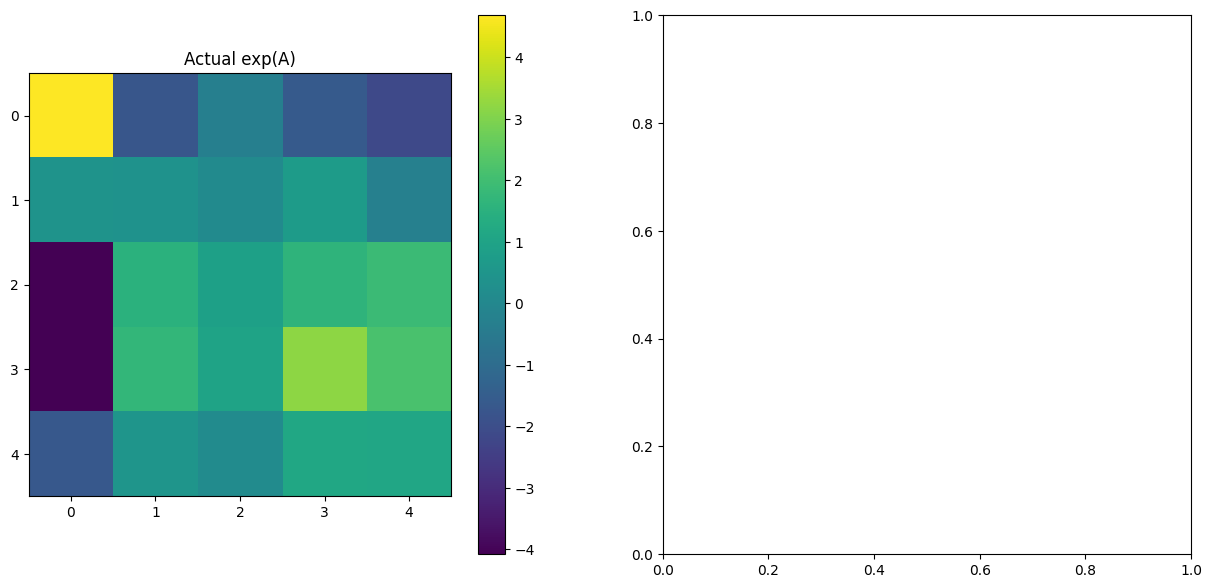

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
im1 = ax1.imshow(actual, cmap='viridis')
ax1.set_title('Actual exp(A)')
plt.colorbar(im1, ax=ax1)

In [28]:
im2 = ax2.imshow(predicted, cmap='viridis')
ax2.set_title('Predicted exp(A)')
plt.colorbar(im2, ax=ax2)

<Figure size 640x480 with 0 Axes>

In [29]:
plt.savefig(os.path.join(save_dir, 'example_comparison.png'))
plt.close()

print("Visualizations have been saved as PNG files.")

Visualizations have been saved as PNG files.


In [30]:
print(f"Observations saved at {save_dir}")

Observations saved at /home/rahulpadmanabhan/Development/ws1/masters_thesis_2/LAWT/notebooks/matrix_exp_results/202427171723948037
